In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal, kl_divergence
import logging
import time
from tqdm import tqdm
import pickle
import os
import random

import sys


sys.path.insert(0, '/Users/abiralshakya/Documents/Research/Topological_Insulators_OnGithub/generative_nmti/cdvae')
import cdvae
# from cdvae.pl_modules.model import CDVAE
# from cdvae.common.data_utils import get_train_val_test_test_loaders
# from cdvae.common.data_utils import get_train_val_test_loaders
# from cdvae.pl_data.dataset import CDVAEDataset

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class CDVAE_TI_Generator:
    """
    Crystal Diffusion Variational Autoencoder (CDVAE) with Reinforcement Learning
    for targeted generation of Topological Insulator materials.
    """
    def __init__(self, config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dtype = torch.float32 #set default tensor type to float32
        logger.info(f"Using device: {self.device}")
        
        # Initialize CDVAE model components
        self.initialize_models()
        
        # Set up optimizers
        self.setup_optimizers()
        
        # Initialize results tracking
        self.results = {
            'rewards': [],
            'z_gap': [],
            'topological_indices': [],
            'formation_energies': [],
            'best_structures': [],
            'best_rewards': [],
        }
        
        # Initialize replay buffer for experience replay
        self.replay_buffer = ReplayBuffer(config['buffer_size'])
        
    def initialize_models(self):
        """Initialize CDVAE encoder, decoder and policy networks."""
        # Import specific model classes
        try:
            from cdvae.pl_modules.decoder import GemNetTDecoder
            from cdvae.common.data_utils import StandardScalerTorch
            from cdvae.common.data_utils import ATOM_TYPES
     
        except ImportError:
            logger.error("Failed to import CDVAE modules. Please ensure CDVAE is installed correctly.")
            raise
            
        # Get dimensions and parameters from config
        self.latent_dim = self.config['latent_dim']
        self.n_elements = len(self.config['elements']) if 'elements' in self.config else len(ATOM_TYPES.get())
        
        #TODO: possibly write an encoder file addition to cdvae
        # Initialize encoder (if using pre-trained weights)
        # if self.config.get('use_encoder', False):
        #     self.encoder = GraphEncoder(
        #         hidden_dim=self.config['hidden_dim'],
        #         latent_dim=self.latent_dim,
        #         use_layer_norm=self.config.get('use_layer_norm', True)
        #     ).to(self.device)
            
        #     if self.config.get('encoder_checkpoint'):
        #         self._load_model(self.encoder, self.config['encoder_checkpoint'])
        # else:
        #     self.encoder = None

        self.encoder = None
            
        # Initialize decoder
        self.decoder = GemNetTDecoder(
            latent_dim=self.latent_dim,
            hidden_dim=self.config['hidden_dim'],
            #cutoff=self.config.get('cutoff', 6.0),
            max_neighbors=self.config.get('max_neighbors', 20),
            #use_layer_norm=self.config.get('use_layer_norm', True)
        ).to(self.device)
        
        if self.config.get('decoder_checkpoint'):
            self._load_model(self.decoder, self.config['decoder_checkpoint'])
            
        # Initialize policy network for RL
        self.policy_net = PolicyNetwork(
            latent_dim=self.latent_dim,
            hidden_dims=self.config.get('policy_hidden_dims', [256, 256]),
            activation=self.config.get('policy_activation', 'relu')
        ).to(self.device)
        
        # Initialize critic network for actor-critic methods
        if self.config.get('use_critic', True):
            self.critic = CriticNetwork(
                latent_dim=self.latent_dim,
                hidden_dims=self.config.get('critic_hidden_dims', [256, 128]),
                activation=self.config.get('critic_activation', 'relu')
            ).to(self.device)
        else:
            self.critic = None
            
        # DFT surrogate models - predict quantum properties directly from latent space
        self.energy_predictor = EnergyPredictor(
            latent_dim=self.latent_dim,
            hidden_dims=self.config.get('energy_predictor_dims', [128, 64])
        ).to(self.device)
        
        self.topological_predictor = TopologicalPredictor(
            latent_dim=self.latent_dim,
            hidden_dims=self.config.get('topo_predictor_dims', [128, 64])
        ).to(self.device)
        
        if self.config.get('surrogate_checkpoint'):
            self._load_surrogate_models(self.config['surrogate_checkpoint'])
        
    def setup_optimizers(self):
        """Set up optimizers for different components."""
        # Policy optimizer
        self.policy_optimizer = torch.optim.Adam(
            self.policy_net.parameters(),
            lr=self.config.get('policy_lr', 1e-4),
            weight_decay=self.config.get('policy_weight_decay', 1e-6)
        )
        
        # Critic optimizer (if using actor-critic)
        if self.critic is not None:
            self.critic_optimizer = torch.optim.Adam(
                self.critic.parameters(),
                lr=self.config.get('critic_lr', 3e-4),
                weight_decay=self.config.get('critic_weight_decay', 1e-6)
            )
        
        # Surrogate model optimizers for fine-tuning
        if self.config.get('train_surrogates', False):
            self.energy_optimizer = torch.optim.Adam(
                self.energy_predictor.parameters(),
                lr=self.config.get('surrogate_lr', 1e-4)
            )
            
            self.topo_optimizer = torch.optim.Adam(
                self.topological_predictor.parameters(),
                lr=self.config.get('surrogate_lr', 1e-4)
            )
            
    def _load_model(self, model, checkpoint_path):
        """Load model weights from checkpoint."""
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device)
            if 'state_dict' in checkpoint:
                # Handle pytorch-lightning checkpoints
                state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items() 
                              if k.startswith('model.')}
                model.load_state_dict(state_dict, strict=False)
            else:
                # Handle regular torch checkpoints
                model.load_state_dict(checkpoint, strict=False)
            logger.info(f"Loaded weights from {checkpoint_path}")
        except Exception as e:
            logger.error(f"Failed to load weights: {e}")
            
    def _load_surrogate_models(self, checkpoint_path):
        """Load surrogate model weights."""
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device)
            self.energy_predictor.load_state_dict(checkpoint['energy_predictor'])
            self.topological_predictor.load_state_dict(checkpoint['topo_predictor'])
            logger.info(f"Loaded surrogate models from {checkpoint_path}")
        except Exception as e:
            logger.error(f"Failed to load surrogate models: {e}")
            
    # def generate_structures(self, batch_size=None):
    #     """Generate crystal structures using the policy network and decoder."""
    #     if batch_size is None:
    #         batch_size = self.config.get('batch_size', 32)
            
    #     # Sample latent vectors from the policy network
    #     z_noise = torch.randn(batch_size, self.latent_dim).to(self.device)
    #     z_sampled, log_probs = self.policy_net(z_noise)
        
    #     # Generate structures using the decoder
    #     with torch.no_grad():
    #         # Assuming decoder outputs a dictionary with:
    #         # - frac_coords: fractional coordinates of atoms
    #         # - atom_types: types of atoms (one-hot or indices)
    #         # - lattice: lattice parameters for unit cells
    #         generated_structures = self.decoder(z_sampled)
            
    #     return generated_structures, z_sampled, log_probs
    # def generate_structures(self, batch_size=None):
    #     """Generate crystal structures using the policy network and decoder."""
    #     if batch_size is None:
    #         batch_size = self.config.get('batch_size', 32)
            
    #     # Sample latent vectors from the policy network
    #     z_noise = torch.randn(batch_size, self.latent_dim).to(self.device)
    #     z_sampled, log_probs = self.policy_net(z_noise)
        
    #     # Create dummy/initial structural parameters
    #     # These values should be adjusted based on your specific use case
    #     pred_frac_coords = torch.rand(batch_size, 10, 3).to(self.device)  # Batch, atoms, 3D coords
    #     pred_atom_types = torch.randint(0, self.n_elements, (batch_size, 10)).to(self.device)  # Batch, atoms
    #     num_atoms = torch.full((batch_size,), 10, dtype=torch.long).to(self.device)  # Fixed at 10 atoms per structure
    #     lengths = torch.rand(batch_size, 3).to(self.device) * 5 + 5  # Random cell lengths between 5-10
    #     angles = torch.rand(batch_size, 3).to(self.device) * 30 + 75  # Random angles between 75-105 degrees
        
    #     # Generate structures using the decoder
    #     with torch.no_grad():
    #         generated_structures = self.decoder(
    #             z_sampled,
    #             pred_frac_coords,
    #             pred_atom_types,
    #             num_atoms,
    #             lengths,
    #             angles
    #         )
            
    #     return generated_structures, z_sampled, log_probs
    
    def generate_structures(self, batch_size=None):
        """Generate crystal structures using the policy network and decoder."""
        if batch_size is None:
            batch_size = self.config.get('batch_size', 32)
            
        # Sample latent vectors from the policy network
        z_noise = torch.randn(batch_size, self.latent_dim, device=self.device, dtype=self.dtype)
        z_sampled, log_probs = self.policy_net(z_noise)
        
        # For testing, let's use a smaller batch size and fewer atoms per crystal
        max_atoms = 5  # Small number of atoms per crystal for testing
        
        # Create a batch where each structure has a different number of atoms
        num_atoms = torch.randint(2, max_atoms+1, (batch_size,), device=self.device)
        
        # Create tensors with proper dimensions
        total_atoms = num_atoms.sum().item()
        
        # Create a batch index
        batch_idx = torch.repeat_interleave(
            torch.arange(batch_size, device=self.device), 
            num_atoms
        )
        
        # Random fractional coordinates for each atom (values between 0 and 1)
        frac_coords = torch.rand(total_atoms, 3, device=self.device, dtype=self.dtype)
        
        # Random atom types
        atom_types = torch.randint(0, self.n_elements, (total_atoms,), device=self.device)
        
        # Random unit cell parameters
        lengths = torch.rand(batch_size, 3, device=self.device, dtype=self.dtype) * 5 + 5  # Between 5-10 Å
        angles = torch.rand(batch_size, 3, device=self.device, dtype=self.dtype) * 30 + 90  # Between 90-120°
        
        # Generate structures using the decoder
        with torch.no_grad():
            try:
                pred_cart_coord_diff, pred_atom_types = self.decoder(
                    z_sampled,
                    frac_coords,
                    atom_types,
                    num_atoms,
                    lengths,
                    angles
                )
                
                # Combine the results
                generated_structures = {
                    'frac_coords': frac_coords,
                    'atom_types': atom_types,
                    'num_atoms': num_atoms,
                    'lengths': lengths,
                    'angles': angles,
                    'pred_cart_coord_diff': pred_cart_coord_diff,
                    'pred_atom_types': pred_atom_types
                }
                
            except Exception as e:
                print(f"Error in decoder: {e}")
                generated_structures = {
                    'frac_coords': frac_coords,
                    'atom_types': atom_types,
                    'num_atoms': num_atoms,
                    'lengths': lengths,
                    'angles': angles
                }
        
        return generated_structures, z_sampled, log_probs
    
    def evaluate_structures(self, structures, z_vectors):
        """Evaluate generated structures using surrogate models."""
        # Predict formation energies
        with torch.no_grad():
            energies = self.energy_predictor(z_vectors)
            
            # Predict topological indices (Z2 invariants, Chern numbers, etc.)
            topo_indices = self.topological_predictor(z_vectors)
            
            # Calculate band gaps (can be part of the topological predictor or separate)
            band_gaps = self.estimate_band_gap(structures, z_vectors)
            
        # Combine predictions into a comprehensive evaluation
        evaluations = {
            'formation_energies': energies.cpu().numpy(),
            'topological_indices': topo_indices.cpu().numpy(),
            'band_gaps': band_gaps.cpu().numpy() if isinstance(band_gaps, torch.Tensor) else band_gaps
        }
        
        return evaluations
    
    def calculate_rewards(self, evaluations):
        """Calculate rewards based on desired material properties."""
        # Extract evaluations
        energies = evaluations['formation_energies']
        topo_indices = evaluations['topological_indices']
        band_gaps = evaluations['band_gaps']
        
        # Convert to numpy for easier manipulation
        if isinstance(energies, torch.Tensor):
            energies = energies.cpu().numpy().squeeze()
        if isinstance(topo_indices, torch.Tensor):
            topo_indices = topo_indices.cpu().numpy()
        if isinstance(band_gaps, torch.Tensor):
            band_gaps = band_gaps.cpu().numpy().squeeze()
            
        # Calculate stability reward component
        # Lower formation energy is better, but must be below threshold to be stable
        stability_threshold = self.config.get('stability_threshold', 0.1)
        stability_rewards = -energies * (energies < stability_threshold)
        
        # Calculate topological reward component
        # For Z2 invariants, we typically want (1;000) for 3D TIs
        # This is a simplified example - actual implementation depends on how topo_indices are represented
        topo_rewards = np.sum(topo_indices * self.config.get('topo_weights', [2.0, 1.0, 1.0, 1.0]), axis=1)
        
        # Calculate band gap reward component
        # Usually want a moderate band gap (not too small, not too large)
        target_gap = self.config.get('target_band_gap', 0.3)  # in eV
        gap_tolerance = self.config.get('gap_tolerance', 0.2)  # in eV
        gap_rewards = 1.0 - np.minimum(np.abs(band_gaps - target_gap) / gap_tolerance, 1.0)
        
        # Combine reward components with configurable weights
        w_stability = self.config.get('w_stability', 1.0)
        w_topological = self.config.get('w_topological', 2.0)
        w_gap = self.config.get('w_gap', 1.5)
        
        combined_rewards = (w_stability * stability_rewards + 
                           w_topological * topo_rewards +
                           w_gap * gap_rewards)
        
        # Create rewards dictionary
        rewards_dict = {
            'total': combined_rewards,
            'stability': stability_rewards,
            'topological': topo_rewards,
            'band_gap': gap_rewards
        }
        
        return rewards_dict
    
    def estimate_band_gap(self, structures, z_vectors):
        """Estimate band gaps of structures using a surrogate model."""
        # This would typically be a separate model or part of topological_predictor
        # For simplicity, we'll use a mock implementation
        batch_size = z_vectors.shape[0]
        
        # Mock band gap estimation (replace with actual model)
        # In practice, this would use a trained neural network or other predictor
        gaps = 0.2 + 0.3 * torch.sigmoid(z_vectors[:, 0]) + 0.1 * torch.randn(batch_size).to(self.device)
        
        return gaps
    
    def reinforce_update(self, rewards, log_probs):
        """Update policy network using REINFORCE algorithm."""
        # Convert to tensor with the right dtype
        rewards_tensor = torch.tensor(rewards, device=self.device, dtype=self.dtype)
        
        # Normalize rewards
        rewards_normalized = (rewards_tensor - rewards_tensor.mean()) / (rewards_tensor.std() + 1e-8)
        
        # Calculate policy loss
        policy_loss = -(log_probs * rewards_normalized).mean()
        
        # Update policy
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        
        # Optional gradient clipping
        if self.config.get('clip_grad', False):
            torch.nn.utils.clip_grad_norm_(
                self.policy_net.parameters(), 
                self.config.get('max_grad_norm', 1.0)
            )
            
        self.policy_optimizer.step()
        
        return policy_loss.item()
        
    # def reinforce_update(self, rewards, log_probs):
    #     """Update policy network using REINFORCE algorithm."""
    #     rewards_tensor = torch.tensor(rewards, device=self.device)
        
    #     # Normalize rewards
    #     rewards_normalized = (rewards_tensor - rewards_tensor.mean()) / (rewards_tensor.std() + 1e-8)
        
    #     # Calculate policy loss
    #     policy_loss = -(log_probs * rewards_normalized).mean()
        
    #     # Update policy
    #     self.policy_optimizer.zero_grad()
    #     policy_loss.backward()
        
    #     # Optional gradient clipping
    #     if self.config.get('clip_grad', False):
    #         torch.nn.utils.clip_grad_norm_(
    #             self.policy_net.parameters(), 
    #             self.config.get('max_grad_norm', 1.0)
    #         )
            
    #     self.policy_optimizer.step()
        
    #     return policy_loss.item()
    
    def actor_critic_update(self, z_vectors, rewards, log_probs):
        """Update policy and critic networks using Actor-Critic algorithm."""
        if self.critic is None:
            return self.reinforce_update(rewards, log_probs)
            
        # Convert rewards to tensor with proper dtype
        rewards_tensor = torch.tensor(rewards, device=self.device, dtype=self.dtype)
        
        # Get critic's value predictions
        value_predictions = self.critic(z_vectors).squeeze()
        
        # Calculate advantages
        advantages = rewards_tensor - value_predictions.detach()
        
        # Calculate policy (actor) loss
        policy_loss = -(log_probs * advantages).mean()
        
        # Calculate value (critic) loss
        critic_loss = F.mse_loss(value_predictions, rewards_tensor)
        
        # Option 1: Combine losses and do a single backward pass
        total_loss = policy_loss + critic_loss
        
        # Zero all gradients
        self.policy_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        
        # Single backward pass
        total_loss.backward()
        
        # Apply gradient clipping if needed
        if self.config.get('clip_grad', False):
            torch.nn.utils.clip_grad_norm_(
                self.policy_net.parameters(), 
                self.config.get('max_grad_norm', 1.0)
            )
            torch.nn.utils.clip_grad_norm_(
                self.critic.parameters(), 
                self.config.get('max_grad_norm', 1.0)
            )
        
        # Update both networks
        self.policy_optimizer.step()
        self.critic_optimizer.step()
        
        return policy_loss.item(), critic_loss.item()
    
    # def actor_critic_update(self, z_vectors, rewards, log_probs):
    #     """Update policy and critic networks using Actor-Critic algorithm."""
    #     if self.critic is None:
    #         return self.reinforce_update(rewards, log_probs)
            
    #     rewards_tensor = torch.tensor(rewards, device=self.device)
        
    #     # Get critic's value predictions
    #     value_predictions = self.critic(z_vectors).squeeze()
        
    #     # Calculate advantages
    #     advantages = rewards_tensor - value_predictions.detach()
        
    #     # Calculate policy (actor) loss
    #     policy_loss = -(log_probs * advantages).mean()
        
    #     # Calculate value (critic) loss
    #     critic_loss = F.mse_loss(value_predictions, rewards_tensor)
        
    #     # Update policy network
    #     self.policy_optimizer.zero_grad()
    #     policy_loss.backward()
    #     if self.config.get('clip_grad', False):
    #         torch.nn.utils.clip_grad_norm_(
    #             self.policy_net.parameters(), 
    #             self.config.get('max_grad_norm', 1.0)
    #         )
    #     self.policy_optimizer.step()
        
    #     # Update critic network
    #     self.critic_optimizer.zero_grad()
    #     critic_loss.backward()
    #     if self.config.get('clip_grad', False):
    #         torch.nn.utils.clip_grad_norm_(
    #             self.critic.parameters(), 
    #             self.config.get('max_grad_norm', 1.0)
    #         )
    #     self.critic_optimizer.step()
        
    #     return policy_loss.item(), critic_loss.item()
    
    def train_step(self):
        """Perform a single training step."""
        # Generate structures
        structures, z_vectors, log_probs = self.generate_structures()
        #print(len(structures))

        if not structures: 
            logger.error("no strucutres generated in this step")
            return  {'mean_reward': 0, 'max_reward': 0, 'mean_energy': 0, 'policy_loss': 0}
        
        # Evaluate structures
        evaluations = self.evaluate_structures(structures, z_vectors)
        
        # Calculate rewards
        rewards_dict = self.calculate_rewards(evaluations)
        total_rewards = rewards_dict['total']
        
        # Store experience in replay buffer
        for i in range(len(total_rewards)):
            self.replay_buffer.add(
                z_vectors[i].detach().cpu().numpy(),
                total_rewards[i],
                log_probs[i].detach().cpu().numpy()
            )
        
        # Update policy using actor-critic or REINFORCE
        if self.critic is not None:
            loss_info = self.actor_critic_update(z_vectors, total_rewards, log_probs)
            policy_loss = loss_info[0]
        else:
            policy_loss = self.reinforce_update(total_rewards, log_probs)
            
        # Track best structures
        best_idx = np.argmax(total_rewards)

        if best_idx >= len(total_rewards):
            logger.warning(f"best_idx {best_idx} out of bounds for total_rewards with length {len(total_rewards)}")
            best_idx = 0  # Fallback to first item

        #print(f"Type of total_rewards: {type(total_rewards)}")
        #print(f"Shape of total_rewards: {total_rewards.shape if hasattr(total_rewards, 'shape') else 'no shape attribute'}")
        #print(f"Type of total_rewards[best_idx]: {type(total_rewards[best_idx])}")
            
        # Fix: Access the scalar value directly without trying to index further
        #best_reward = float(total_rewards[best_idx])  # Remove the [0] indexing
        reward_value = total_rewards[best_idx]
        if isinstance(reward_value, np.ndarray):
            if reward_value.size == 1:
                best_reward = float(reward_value.item())
            else:
                # If it's an array with multiple values, take the first one
                best_reward = float(reward_value[0])
        else:
            # If it's already a scalar type (int, float)
            best_reward = float(reward_value)

        # Determine if this iteration’s best is a new overall best
        if len(self.results['best_rewards']) == 0:
            is_new_best = True
        else:
            prev_best = max(self.results['best_rewards'])
            # force a Python bool
            is_new_best = bool(best_reward > prev_best)

        if is_new_best:
            best_struct = {
                'frac_coords': structures['frac_coords'][best_idx],
                'atom_types':  structures['atom_types'][best_idx],
                'num_atoms':   structures['num_atoms'][best_idx],
                'lengths':     structures['lengths'][best_idx],
                'angles':      structures['angles'][best_idx],
            }
            # optional fields
            pccd = structures.get('pred_cart_coord_diff', None)
            if pccd is not None:
                best_struct['pred_cart_coord_diff'] = pccd[best_idx]
            pact = structures.get('pred_atom_types', None)
            if pact is not None:
                best_struct['pred_atom_types'] = pact[best_idx]

            self.results['best_structures'].append(best_struct)

    
        # # Update current best if this is better
        # if not self.results['best_rewards'] or best_reward > max(self.results['best_rewards']):
        #     self.results['best_structures'].append(structures[best_idx])

        # if not self.results['best_rewards'] or best_reward > max(self.results['best_rewards']):
        #     # Core fields (always present)
        #     best_struct = {
        #         'frac_coords': structures['frac_coords'][best_idx],
        #         'atom_types':  structures['atom_types'][best_idx],
        #         'num_atoms':   structures['num_atoms'][best_idx],
        #         'lengths':     structures['lengths'][best_idx],
        #         'angles':      structures['angles'][best_idx],
        #     }
        #     # Optional fields (guard against None)
        #     pccd = structures.get('pred_cart_coord_diff', None)
        #     if pccd is not None:
        #         best_struct['pred_cart_coord_diff'] = pccd[best_idx]
        #     pact = structures.get('pred_atom_types', None)
        #     if pact is not None:
        #         best_struct['pred_atom_types'] = pact[best_idx]

        # self.results['best_structures'].append(best_struct)

                    
        # Store results
        self.results['rewards'].append(np.mean(total_rewards))
        self.results['formation_energies'].append(np.mean(evaluations['formation_energies']))
        self.results['topological_indices'].append(np.mean(evaluations['topological_indices']))
        self.results['best_rewards'].append(best_reward)
        
        return {
            'mean_reward': np.mean(total_rewards),
            'max_reward': np.max(total_rewards),
            'mean_energy': np.mean(evaluations['formation_energies']),
            'policy_loss': policy_loss
        }
    
    def train(self, num_iterations=None):
        """Train the model for the specified number of iterations."""
        if num_iterations is None:
            num_iterations = self.config.get('num_iterations', 500)
            
        logger.info(f"Starting training for {num_iterations} iterations")
        
        for iteration in tqdm(range(num_iterations)):
            # Perform a training step
            step_results = self.train_step()
            
            # Log progress periodically
            if iteration % self.config.get('log_frequency', 10) == 0:
                logger.info(
                    f"Iteration {iteration} | "
                    f"Mean Reward: {step_results['mean_reward']:.4f} | "
                    f"Max Reward: {step_results['max_reward']:.4f} | "
                    f"Mean Energy: {step_results['mean_energy']:.4f} | "
                    f"Policy Loss: {step_results['policy_loss']:.4f}"
                )
                
            # Save checkpoints periodically
            if iteration % self.config.get('save_frequency', 100) == 0 and iteration > 0:
                self.save_checkpoint(f"checkpoint_iter_{iteration}.pt")
                
        logger.info("Training completed")
        self.save_checkpoint("final_checkpoint.pt")
        self.save_results("training_results.pkl")
        
    def save_checkpoint(self, filename):
        """Save model checkpoint."""
        checkpoint_dir = self.config.get('checkpoint_dir', './checkpoints')
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        checkpoint_path = os.path.join(checkpoint_dir, filename)
        
        checkpoint = {
            'policy_state_dict': self.policy_net.state_dict(),
            'policy_optimizer': self.policy_optimizer.state_dict(),
            'config': self.config,
            'iteration': len(self.results['rewards'])
        }
        
        if self.critic is not None:
            checkpoint['critic_state_dict'] = self.critic.state_dict()
            checkpoint['critic_optimizer'] = self.critic_optimizer.state_dict()
            
        torch.save(checkpoint, checkpoint_path)
        logger.info(f"Saved checkpoint to {checkpoint_path}")
        
    def save_results(self, filename):
        """Save training results."""
        results_dir = self.config.get('results_dir', './results')
        os.makedirs(results_dir, exist_ok=True)
        
        results_path = os.path.join(results_dir, filename)
        
        with open(results_path, 'wb') as f:
            pickle.dump(self.results, f)
            
        logger.info(f"Saved results to {results_path}")
        
    def load_checkpoint(self, checkpoint_path):
        """Load model from checkpoint."""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        self.policy_net.load_state_dict(checkpoint['policy_state_dict'])
        self.policy_optimizer.load_state_dict(checkpoint['policy_optimizer'])
        
        if self.critic is not None and 'critic_state_dict' in checkpoint:
            self.critic.load_state_dict(checkpoint['critic_state_dict'])
            self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
            
        logger.info(f"Loaded checkpoint from {checkpoint_path}")
        return checkpoint.get('iteration', 0)


class PolicyNetwork(nn.Module):
    """Policy network for RL-based latent space exploration."""
    
    def __init__(self, latent_dim, hidden_dims=[256, 256], activation='relu'):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        # Build network layers
        layers = []
        input_dim = latent_dim
        
        # Map activation function string to actual function
        act_fn = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.2),
            'tanh': nn.Tanh(),
            'silu': nn.SiLU()
        }.get(activation.lower(), nn.ReLU())
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(act_fn)
            input_dim = hidden_dim
            
        # Output layer for mean
        self.fc_layers = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(input_dim, latent_dim)
        
        # Learnable log std for exploration
        self.log_std = nn.Parameter(torch.zeros(latent_dim))
        
        # Apply weight initialization
        self._initialize_weights()
        
    # def _initialize_weights(self):
    #     """Initialize network weights."""
    #     for m in self.modules():
    #         if isinstance(m, nn.Linear):
    #             nn.init.xavier_normal_(m.weight)
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0.0)
    
    def _initialize_weights(self):
        """Initialize network weights."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
                
                # Ensure dtype is correct
                m.weight.data = m.weight.data.to(dtype=torch.float32)
                if m.bias is not None:
                    m.bias.data = m.bias.data.to(dtype=torch.float32)
    
    def forward(self, z_noise):
        """
        Forward pass through the policy network.
        
        Args:
            z_noise: Random noise tensor of shape [batch_size, latent_dim]
            
        Returns:
            z_sampled: Sampled latent vectors
            log_probs: Log probabilities of the sampled vectors
        """
        x = self.fc_layers(z_noise)
        mu = self.fc_mu(x)
        
        # Get standard deviation from learnable parameter
        std = torch.exp(self.log_std.clamp(-20, 2))  # Clamp for stability
        
        # Create normal distribution
        dist = Normal(mu, std)
        
        # Sample using reparameterization trick
        z_sampled = dist.rsample()
        
        # Calculate log probabilities
        log_probs = dist.log_prob(z_sampled).sum(dim=-1)
        
        return z_sampled, log_probs


class CriticNetwork(nn.Module):
    """Critic network for actor-critic method."""
    
    def __init__(self, latent_dim, hidden_dims=[256, 128], activation='relu'):
        super().__init__()
        
        # Build network layers
        layers = []
        input_dim = latent_dim
        
        # Map activation function string to actual function
        act_fn = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.2),
            'tanh': nn.Tanh(),
            'silu': nn.SiLU()
        }.get(activation.lower(), nn.ReLU())
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(act_fn)
            input_dim = hidden_dim
            
        # Output layer - single value output
        layers.append(nn.Linear(input_dim, 1))
        
        self.model = nn.Sequential(*layers)
        
        # Apply weight initialization
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize network weights."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
    
    def forward(self, z):
        """
        Forward pass through the critic network.
        
        Args:
            z: Latent vector of shape [batch_size, latent_dim]
            
        Returns:
            value: Predicted value of the state
        """
        return self.model(z)


class EnergyPredictor(nn.Module):
    """Surrogate model to predict formation energy from latent space."""
    
    def __init__(self, latent_dim, hidden_dims=[128, 64]):
        super().__init__()
        
        # Build network layers
        layers = []
        input_dim = latent_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
            
        # Output layer - single value for formation energy
        layers.append(nn.Linear(input_dim, 1))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, z):
        """Predict formation energy from latent vector."""
        return self.model(z)


class TopologicalPredictor(nn.Module):
    """
    Surrogate model to predict topological invariants (Z2, Chern number) 
    from latent space.
    """
    
    def __init__(self, latent_dim, hidden_dims=[128, 64], num_invariants=4):
        super().__init__()
        
        # Build network layers
        layers = []
        input_dim = latent_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
            
        # Output layer - multiple values for topological invariants
        # For 3D topological insulators, typically 4 Z2 invariants (ν₀;ν₁ν₂ν₃)
        self.feature_extractor = nn.Sequential(*layers)
        self.invariant_head = nn.Linear(input_dim, num_invariants)
        
    def forward(self, z):
        """Predict topological invariants from latent vector."""
        features = self.feature_extractor(z)
        # Apply sigmoid to constrain outputs between 0 and 1
        # In practice, these would be discretized to 0 or 1 when interpreting
        invariants = torch.sigmoid(self.invariant_head(features))
        return invariants


class ReplayBuffer:
    """Experience replay buffer for more stable training."""
    
    def __init__(self, max_size=10000):
        self.max_size = max_size
        self.buffer = []
        self.position = 0   
        
    def add(self, z, reward, log_prob):
        """Add experience to buffer."""
        if len(self.buffer) < self.max_size:
            self.buffer.append(None)
        self.buffer[self.position] = (z, reward, log_prob)
        self.position = (self.position + 1) % self.max_size
        
    def sample(self, batch_size):
        """Sample a batch of experiences."""
        batch = random.sample(self.buffer, min(batch_size, len(self.buffer)))
        z, rewards, log_probs = map(np.array, zip(*batch))
        return z, rewards, log_probs
        
    def __len__(self):
        """Return current buffer size."""
        return len(self.buffer)

In [4]:
import cdvae

# Example configuration
def get_default_config():
    """Get default configuration for CDVAE + RL training."""
    return {
        # Model dimensions
        "latent_dim": 64,
        "hidden_dim": 128,
        
        # Elements to consider
        "elements": ["Si", "Ge", "Sn", "Pb", "Bi", "Sb", "Te", "Se", "O"],
        
        # Training parameters
        "batch_size": 32,
        "num_iterations": 1000,
        "policy_lr": 1e-4,
        "critic_lr": 3e-4,
        "surrogate_lr": 1e-4,
        
        # RL parameters
        "use_critic": True,  # Use actor-critic instead of REINFORCE
        "clip_grad": True,
        "max_grad_norm": 1.0,
        "buffer_size": 5000,  # Replay buffer size
        
        # Reward components
        "stability_threshold": 0.1,
        "target_band_gap": 0.3,  # Target band gap in eV
        "gap_tolerance": 0.2,    # Acceptable deviation from target
        "topo_weights": [2.0, 1.0, 1.0, 1.0],  # Weights for Z2 invariants
        
        # Reward weights
        "w_stability": 1.0,
        "w_topological": 2.0,
        "w_gap": 1.5,
        
        # Logging and checkpoints
        "log_frequency": 10,
        "save_frequency": 100,
        "checkpoint_dir": "./checkpoints",
        "results_dir": "./results"
    }

/Users/abiralshakya/Documents/Research/Topological_Insulators_OnGithub/TIvenv/lib/python3.12/site-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)
2025-04-07 09:16:35,629 - INFO - Using device: cpu
/Users/abiralshakya/Documents/Research/Topological_Insulators_OnGithub/TIvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-07 09:16:38,922 - INFO - Starting training for 500 iterations
  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/sb/srkfc7tj3319314qk68v5cch0000gn/T/ipykernel_75105/1869667748.py:456: UserWar

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: Boolean value of Tensor with more than one value is ambiguous
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self


2025-04-07 09:16:39,203 - WARNING - best_idx 667 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,212 - WARNING - best_idx 221 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,213 - INFO - Iteration 20 | Mean Reward: 5.3965 | Max Reward: 6.3849 | Mean Energy: 0.1900 | Policy Loss: 208.7959
2025-04-07 09:16:39,222 - WARNING - best_idx 789 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,229 - WARNING - best_idx 566 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,237 - WARNING - best_idx 1004 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,256 - WARNING - best_idx 422 out of bounds for total_rewards with length 32
  6%|▌         | 30/500 [00:00<00:04, 105.97it/s]2025-04-07 09:16:39,282 - WARNING - best_idx 183 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,283 - INFO - Iteration 30 | Mean Reward: 5.4233 | Max Reward: 6.3001 | Mean Energy: 0.1502 | Policy Loss: -35.8127
2025-04-

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:39,404 - WARNING - best_idx 56 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,411 - WARNING - best_idx 128 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,419 - WARNING - best_idx 883 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,420 - INFO - Iteration 50 | Mean Reward: 5.5274 | Max Reward: 6.2583 | Mean Energy: 0.1755 | Policy Loss: 31.1390
2025-04-07 09:16:39,428 - WARNING - best_idx 271 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,436 - WARNING - best_idx 55 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,443 - WARNING - best_idx 893 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,479 - WARNING - best_idx 43 out of bounds for total_rewards with length 32
 12%|█▏        | 60/500 [00:00<00:03, 130.23it/s]2025-04-07 09:16:39,485 - WARNING - best_idx 546 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,486 - INFO - Iteration 60 | Mean

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:39,611 - INFO - Iteration 80 | Mean Reward: 5.3809 | Max Reward: 6.1780 | Mean Energy: 0.1758 | Policy Loss: -6.9504
2025-04-07 09:16:39,636 - WARNING - best_idx 927 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,643 - WARNING - best_idx 946 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,672 - WARNING - best_idx 639 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,673 - INFO - Iteration 90 | Mean Reward: 5.4332 | Max Reward: 6.3446 | Mean Energy: 0.1691 | Policy Loss: 3.9103
2025-04-07 09:16:39,684 - WARNING - best_idx 37 out of bounds for total_rewards with length 32
 19%|█▊        | 93/500 [00:00<00:02, 147.19it/s]2025-04-07 09:16:39,692 - WARNING - best_idx 640 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,699 - WARNING - best_idx 62 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,718 - WARNING - best_idx 37 out of bounds for total_rewards with length 32
2025-04-07 09:1

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:39,833 - WARNING - best_idx 729 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,840 - WARNING - best_idx 210 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,860 - WARNING - best_idx 90 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,871 - WARNING - best_idx 346 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,872 - INFO - Iteration 120 | Mean Reward: 5.5244 | Max Reward: 6.3512 | Mean Energy: 0.1744 | Policy Loss: 7.6112
2025-04-07 09:16:39,891 - WARNING - best_idx 529 out of bounds for total_rewards with length 32
 25%|██▍       | 123/500 [00:00<00:02, 140.63it/s]2025-04-07 09:16:39,912 - WARNING - best_idx 865 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,933 - WARNING - best_idx 44 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,956 - WARNING - best_idx 53 out of bounds for total_rewards with length 32
2025-04-07 09:16:39,957 - INFO - Iteration 130 | Me

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:40,023 - WARNING - best_idx 668 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,024 - INFO - Iteration 140 | Mean Reward: 5.4550 | Max Reward: 6.2288 | Mean Energy: 0.1719 | Policy Loss: 20.8552
2025-04-07 09:16:40,044 - WARNING - best_idx 220 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,053 - WARNING - best_idx 476 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,070 - WARNING - best_idx 44 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,078 - WARNING - best_idx 51 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,095 - WARNING - best_idx 752 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,111 - INFO - Iteration 150 | Mean Reward: 5.4920 | Max Reward: 6.2707 | Mean Energy: 0.1917 | Policy Loss: 8.5930
2025-04-07 09:16:40,119 - WARNING - best_idx 470 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,124 - WARNING - best_idx 202 out of bound

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: Boolean value of Tensor with more than one value is ambiguous
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: Boolean value of Tensor with more than one value is ambiguous
Error in decoder: index out of

2025-04-07 09:16:40,234 - WARNING - best_idx 39 out of bounds for total_rewards with length 32
 34%|███▍      | 170/500 [00:01<00:02, 141.81it/s]2025-04-07 09:16:40,240 - INFO - Iteration 170 | Mean Reward: 5.4005 | Max Reward: 6.2623 | Mean Energy: 0.2036 | Policy Loss: -4.8076
2025-04-07 09:16:40,261 - WARNING - best_idx 685 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,285 - WARNING - best_idx 395 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,303 - WARNING - best_idx 160 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,304 - INFO - Iteration 180 | Mean Reward: 5.4945 | Max Reward: 6.3741 | Mean Energy: 0.1537 | Policy Loss: 8.9759
2025-04-07 09:16:40,310 - WARNING - best_idx 981 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,317 - WARNING - best_idx 870 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,323 - WARNING - best_idx 439 out of bounds for total_rewards with length 32
 37%|███▋ 

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: Boolean value of Tensor with more than one value is ambiguous
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: in

2025-04-07 09:16:40,430 - WARNING - best_idx 527 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,430 - INFO - Iteration 200 | Mean Reward: 5.4171 | Max Reward: 6.1230 | Mean Energy: 0.1486 | Policy Loss: 22.6533
2025-04-07 09:16:40,435 - INFO - Saved checkpoint to ./checkpoints/checkpoint_iter_200.pt
 40%|████      | 202/500 [00:01<00:02, 147.46it/s]2025-04-07 09:16:40,451 - WARNING - best_idx 32 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,458 - WARNING - best_idx 67 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,470 - WARNING - best_idx 261 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,476 - WARNING - best_idx 623 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,480 - WARNING - best_idx 359 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,487 - WARNING - best_idx 40 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,494 - WARNING - best_idx 41 out of b

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: Boolean value of Tensor with more than one value is ambiguous
Error in decoder: Boolean value of Tensor with more than one value is ambiguous
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of

2025-04-07 09:16:40,632 - INFO - Iteration 230 | Mean Reward: 5.4453 | Max Reward: 6.2785 | Mean Energy: 0.1518 | Policy Loss: -10.1120
2025-04-07 09:16:40,646 - WARNING - best_idx 711 out of bounds for total_rewards with length 32
 47%|████▋     | 234/500 [00:01<00:01, 149.48it/s]2025-04-07 09:16:40,661 - WARNING - best_idx 377 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,667 - WARNING - best_idx 1019 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,674 - WARNING - best_idx 107 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,680 - WARNING - best_idx 349 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,701 - INFO - Iteration 240 | Mean Reward: 5.5124 | Max Reward: 6.2920 | Mean Energy: 0.1829 | Policy Loss: 20.9632
 50%|████▉     | 249/500 [00:01<00:01, 146.06it/s]2025-04-07 09:16:40,775 - WARNING - best_idx 791 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,775 - INFO - Iteration 250 | Mea

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:40,841 - INFO - Iteration 260 | Mean Reward: 5.5143 | Max Reward: 6.3073 | Mean Energy: 0.1876 | Policy Loss: 16.5298
2025-04-07 09:16:40,848 - WARNING - best_idx 76 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,855 - WARNING - best_idx 171 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,868 - WARNING - best_idx 85 out of bounds for total_rewards with length 32
 53%|█████▎    | 265/500 [00:01<00:01, 147.35it/s]2025-04-07 09:16:40,874 - WARNING - best_idx 484 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,892 - WARNING - best_idx 109 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,898 - WARNING - best_idx 971 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,904 - WARNING - best_idx 911 out of bounds for total_rewards with length 32
2025-04-07 09:16:40,904 - INFO - Iteration 270 | Mean Reward: 5.7441 | Max Reward: 6.2756 | Mean Energy: 0.1598 | Policy Loss: 21.4207
2025-04-07

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:41,045 - WARNING - best_idx 936 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,051 - WARNING - best_idx 33 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,058 - WARNING - best_idx 403 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,065 - WARNING - best_idx 696 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,072 - WARNING - best_idx 860 out of bounds for total_rewards with length 32
 60%|█████▉    | 299/500 [00:02<00:01, 156.92it/s]2025-04-07 09:16:41,079 - WARNING - best_idx 643 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,085 - WARNING - best_idx 229 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,086 - INFO - Iteration 300 | Mean Reward: 5.5598 | Max Reward: 6.1818 | Mean Energy: 0.1551 | Policy Loss: 17.4483
2025-04-07 09:16:41,090 - INFO - Saved checkpoint to ./checkpoints/checkpoint_iter_300.pt
2025-04-07 09:16:41,102 - WARNING - best_idx 50 out of

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:41,264 - WARNING - best_idx 229 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,271 - WARNING - best_idx 52 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,280 - WARNING - best_idx 685 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,282 - INFO - Iteration 330 | Mean Reward: 5.5866 | Max Reward: 6.3093 | Mean Energy: 0.1737 | Policy Loss: 17.5954
 66%|██████▌   | 331/500 [00:02<00:01, 153.91it/s]2025-04-07 09:16:41,300 - WARNING - best_idx 250 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,311 - WARNING - best_idx 33 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,318 - WARNING - best_idx 61 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,326 - WARNING - best_idx 49 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,332 - WARNING - best_idx 57 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,339 - WARNING - best_idx 604 out

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:41,451 - WARNING - best_idx 630 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,487 - WARNING - best_idx 84 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,487 - INFO - Iteration 360 | Mean Reward: 5.3979 | Max Reward: 6.3217 | Mean Energy: 0.1878 | Policy Loss: -3.2121
2025-04-07 09:16:41,499 - WARNING - best_idx 116 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,505 - WARNING - best_idx 548 out of bounds for total_rewards with length 32
 73%|███████▎  | 364/500 [00:02<00:00, 152.05it/s]2025-04-07 09:16:41,513 - WARNING - best_idx 337 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,519 - WARNING - best_idx 208 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,531 - WARNING - best_idx 49 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,541 - WARNING - best_idx 793 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,548 - WARNING - best_idx 630 

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: Boolean value of Tensor with more than one value is ambiguous
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: in

2025-04-07 09:16:41,661 - WARNING - best_idx 510 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,669 - WARNING - best_idx 657 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,670 - INFO - Iteration 390 | Mean Reward: 5.4585 | Max Reward: 6.3234 | Mean Energy: 0.1571 | Policy Loss: 3.6721
2025-04-07 09:16:41,676 - WARNING - best_idx 640 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,682 - WARNING - best_idx 712 out of bounds for total_rewards with length 32
 79%|███████▉  | 397/500 [00:02<00:00, 157.74it/s]2025-04-07 09:16:41,712 - WARNING - best_idx 887 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,724 - WARNING - best_idx 675 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,730 - INFO - Iteration 400 | Mean Reward: 5.3719 | Max Reward: 6.2386 | Mean Energy: 0.1537 | Policy Loss: -1.6577
2025-04-07 09:16:41,734 - INFO - Saved checkpoint to ./checkpoints/checkpoint_iter_400.pt
2025-04-07 09:1

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:41,854 - INFO - Iteration 420 | Mean Reward: 5.4108 | Max Reward: 6.3630 | Mean Energy: 0.1667 | Policy Loss: 0.5390
2025-04-07 09:16:41,861 - WARNING - best_idx 757 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,886 - WARNING - best_idx 913 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,891 - WARNING - best_idx 617 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,897 - WARNING - best_idx 567 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,909 - WARNING - best_idx 106 out of bounds for total_rewards with length 32
 86%|████████▌ | 430/500 [00:02<00:00, 160.41it/s]2025-04-07 09:16:41,916 - INFO - Iteration 430 | Mean Reward: 5.6208 | Max Reward: 6.2641 | Mean Energy: 0.1548 | Policy Loss: 27.6819
2025-04-07 09:16:41,923 - WARNING - best_idx 62 out of bounds for total_rewards with length 32
2025-04-07 09:16:41,929 - WARNING - best_idx 606 out of bounds for total_rewards with length 32
2025-04-07

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in d

2025-04-07 09:16:42,062 - WARNING - best_idx 87 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,069 - WARNING - best_idx 37 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,074 - WARNING - best_idx 816 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,081 - WARNING - best_idx 44 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,087 - WARNING - best_idx 379 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,094 - WARNING - best_idx 59 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,106 - WARNING - best_idx 483 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,106 - INFO - Iteration 460 | Mean Reward: 5.5023 | Max Reward: 6.1354 | Mean Energy: 0.1618 | Policy Loss: -10.0372
2025-04-07 09:16:42,113 - WARNING - best_idx 976 out of bounds for total_rewards with length 32
 93%|█████████▎| 463/500 [00:03<00:00, 158.72it/s]2025-04-07 09:16:42,126 - WARNING - best_idx 418 o

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: Boolean value of Tensor with more than one value is ambiguous
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: in

2025-04-07 09:16:42,270 - WARNING - best_idx 945 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,280 - WARNING - best_idx 47 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,300 - WARNING - best_idx 978 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,300 - INFO - Iteration 490 | Mean Reward: 5.4256 | Max Reward: 6.3369 | Mean Energy: 0.1240 | Policy Loss: -24.3794
2025-04-07 09:16:42,307 - WARNING - best_idx 888 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,312 - WARNING - best_idx 370 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,325 - WARNING - best_idx 552 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,331 - WARNING - best_idx 320 out of bounds for total_rewards with length 32
 99%|█████████▉| 496/500 [00:03<00:00, 156.90it/s]2025-04-07 09:16:42,343 - WARNING - best_idx 973 out of bounds for total_rewards with length 32
2025-04-07 09:16:42,349 - WARNING - best_idx 45

Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self
Error in decoder: index out of range in self


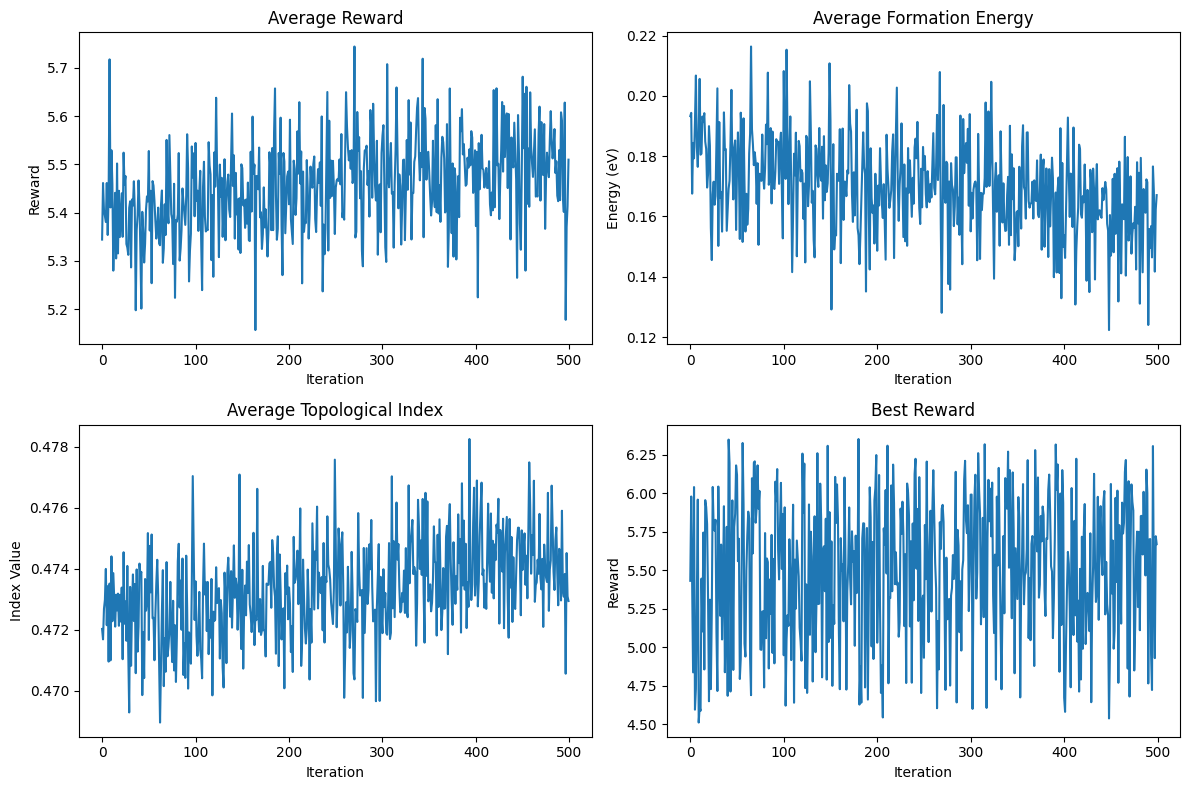

Error in decoder: index out of range in self


In [5]:
# Example usage
if __name__ == "__main__":
    import random
    import matplotlib.pyplot as plt
    
    # Set seeds for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.set_default_tensor_type(torch.FloatTensor)

    # Get default configuration
    config = get_default_config()
    
    # Create training framework
    # Set default tensor type
    ti_generator = CDVAE_TI_Generator(config)
    
    # Train the model
    ti_generator.train(num_iterations=500)
    
    # Plot training results
    plt.figure(figsize=(12, 8))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(ti_generator.results['rewards'])
    plt.title('Average Reward')
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    
    # Plot formation energies
    plt.subplot(2, 2, 2)
    plt.plot(ti_generator.results['formation_energies'])
    plt.title('Average Formation Energy')
    plt.xlabel('Iteration')
    plt.ylabel('Energy (eV)')
    
    # Plot topological indices
    plt.subplot(2, 2, 3)
    plt.plot(ti_generator.results['topological_indices'])
    plt.title('Average Topological Index')
    plt.xlabel('Iteration')
    plt.ylabel('Index Value')
    
    # Plot best rewards
    plt.subplot(2, 2, 4)
    plt.plot(ti_generator.results['best_rewards'])
    plt.title('Best Reward')
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    
    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()
    
    # Generate some final structures
    structures, _, _ = ti_generator.generate_structures()